# 4. A Closer Look on Maps
Wednesday, November 7th, 2018 <br>
Felicia Nurindrawati

The Maps library deals with mapping one form of object with another. We use this typically to map survey with the forward problem. It has a lot of physics involved. <br>
(src:https://github.com/simpeg/simpeg/blob/master/SimPEG/Maps.py)<br>


To make this guide relevant to our Gravity problem, let's have the snippet of code up until our first instance of using Maps:

In [3]:
import numpy as np
import matplotlib.pyplot as plt

#This one contains all the main packages you need from SimPEG. 
from SimPEG import Mesh, Utils, Maps, Regularization, DataMisfit, Optimization, InvProblem, Directives, Inversion, PF

dx = 5.
incr = 1.3
ymax = 15.

hxind = [(dx, dx, -incr), (dx, 15), (dx, dx, incr)]
hyind = [(dx, dx, -incr), (dx, 15), (dx, dx, incr)]
hzind = [(dx, dx, -incr), (dx, 7), (3.5, 1), (2, dx)]

mesh = Mesh.TensorMesh([hxind, hyind, hzind], 'CCC')
#C means center in the first axis, likewise CC means it centers in second axis, and CCC is center on all axis
midx = int(mesh.nCx/2) #for this problem, our nCx and nCy are 25, because we have 5+15+5 points every h
midy = int(mesh.nCy/2)

[xx, yy] = np.meshgrid(mesh.vectorNx, mesh.vectorNy)
zz = -np.exp((xx**2+yy**2)/75**2) + mesh.vectorNz[-1]

### This is usually where you load your topography file, but let's make it synthetic for now
topo = np.c_[Utils.mkvc(xx), Utils.mkvc(yy),  Utils.mkvc(zz)]

actv = Utils.surface2ind_topo(mesh,topo,'N') #gets active indices from topography 
#input: mesh to which the function discretize the topography
#topo as in t\he topography data
#N: nodes, CC: center

actv = np.asarray([inds for inds, elem in enumerate(actv,1) if elem], dtype=int)-1
#creates an array for the activated cells in the previous line
actvMap = Maps.InjectActiveCells(mesh, actv, -100)

nC = len(actv)

For a closer look on SimPEG's own documentation of maps, refer to this link: <br>
http://docs.simpeg.xyz/content/api_core/api_Maps.html?highlight=maps

### What is a Map?
In SimPEG a Map object stores a vector and transforms it into another vector of another space. For example suppose we have a function that goes like this: 
$$m = log(\sigma) $$
So if we want to find/map the relation between $\sigma$ and $m$, we can simbolyze this relation with a mapping operator $M$, such as the following<br>
$$\sigma = M(m) $$
This is pretty much what *SimPEG.Maps.ExpMap* does. Refer to the lines of code below in a python representation of the problem. This basically maps the survey grid(mesh M) with the model (m). 

### Derivatives
Apparently the maps that we have make it easier for us to take derivatives. Here is an examples of taking the derivatives with Maps and checking the validity of the derivative too (though I honestly don't know what exactly is this deriving ._. ):

Testing ExpMap(100,100)
==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    2.152e+00     1.665e-01      nan
 1   1.00e-02    2.147e-01     1.658e-03      2.002
 2   1.00e-03    2.148e-02     1.658e-05      2.000
 3   1.00e-04    2.148e-03     1.658e-07      2.000
========================= PASS! =========================
Happy little convergence test!



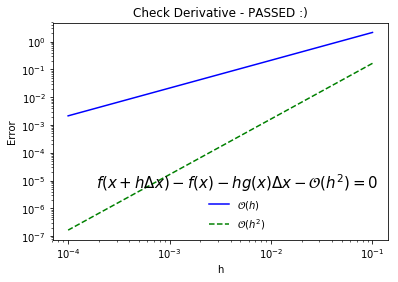

True

In [28]:
import numpy as np
from SimPEG import Mesh, Maps
import matplotlib.pyplot as plt
M = Mesh.TensorMesh([100])
expMap = Maps.ExpMap(M) 
m = np.zeros(M.nC)
m[M.vectorCCx>0.5] = 1.0 
expMap.test(m, plotIt=True) #tests the derivative

The classes that we have for *Maps* are: <br>
- **IdentityMap:** This creates the SimPEG map. There are some properties for this class, including: <br>
  - **nP:** number of parameters the mapping accepts<br>
  - **shape:** Returns the shape of the map as a tuple (mesh.nC,nP), where nC is number of cells in the mesh<br>
   Furthermore, the class has some methods that includes: <br>
   - **deriv:** accepts an array of model, and returns the derivative of the transformed model
   - **test**: test the dericative of the mapping process (returns a bool)


In [29]:
M = Mesh.TensorMesh([100]) # Create a mesh
expMap = Maps.ExpMap(M)    # Create a mapping
m = np.zeros(M.nC)         # Create a model vector
m[M.vectorCCx>0.5] = 1.0   # Set half of it to 1.0 
#vectorCCx: cell-cemtered grid vector 1D in x-direction
sig = expMap * m           # Apply the mapping using *


- **ComboMap(IdentityMap)**: Combination of various maps. Can be implemented by combining two map objects with *****. Also does the derivative tests in the combined-map to check if the derivatives are correct. The properties of this class include: <br>
    - **shape:** Returns the shape of the map as a tuple 
    - **nP**: number of parameters the mapping accepts 
    - **deriv**: Derivative of the map<br>
    An example of the implementation of this can be seen in the lines of code below: <br>

In [26]:
M = Mesh.TensorMesh([7,5])
v1dMap = Maps.SurjectVertical1D(M) #Map 1
expMap = Maps.ExpMap(M) #Map 2
myMap = expMap * v1dMap  #NOTE: combining the two maps only need the '*' operator!
m = np.r_[0.2,1,0.1,2,2.9] # only 5 model parameters! 
sig = myMap * m

- **Projection(IdentityMap)**: Map that is used to rearrange/select parameters. This is used as a helper class for another class explained later. The parameters of the class include:<br>
    - **nP:** Number of parameters
    - **index(array):** Indices to select
    - **shape(tuple):** Shape of matric operation
    - **deriv**: accepts model array and returns the derivative of the transformed model


- **Wires(object)**
    - **nP**
- **selfConsistentEffectiveMedium(IdentityMap)**:
    - **tol**
    - **sigstart**
    - **wiener_bounds**
    - **hashin_shtrikman_bounds**
    - **hashin_shtrikman_bounds_anisotropic**
    - **getQ**
    - **getA**
    - **getR**
    - **getdR**
    - **deriv**
    - **inverse**<br>

Mesh-Independent Maps (everyone of these have *deriv* and *inverse*)
- **ExpMap(IdentityMap)**:
- **ReciprocalMap(identityMap)**:
- **LogMap(IdentityMap)**:
- **ChiMap(IdentityMap)**:
- **MuRelative(IdentityMap)**:
- **Weighting(IdentityMap)**:
- **ComplexMap(IdentityMap)**:

Surjection, Injection, Interpolation Maps (everyone of these have *deriv*, *nP*, *inverse*)
- **SurjectFull(IdentityMap):**
- **SurjectVertical1D(IdentityMap):**
- **Surject2Dto3D(IdentityMap)**:
- **Mesh2Mesh(IdentityMap)**:
- **InjectActiveCells(IdentityMap)**:


Mesh2Mesh Example


Text(0.5,1,'Fine Mesh (Interpolated)')

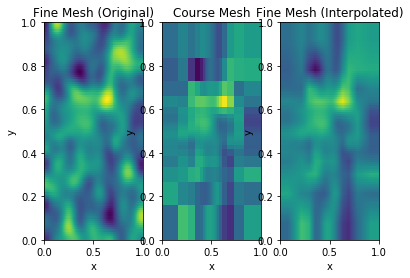

In [36]:
print("Mesh2Mesh Example")
M = Mesh.TensorMesh([100, 100])
h1 = Utils.meshTensor([(6, 7, -1.5), (6, 10), (6, 7, 1.5)])
h1 = h1/h1.sum()
M2 = Mesh.TensorMesh([h1, h1])
V = Utils.ModelBuilder.randomModel(M.vnC, seed=79, its=50)
v = Utils.mkvc(V)
modh = Maps.Mesh2Mesh([M, M2])
modH = Maps.Mesh2Mesh([M2, M])
H = modH * v
h = modh * H
ax = plt.subplot(131)
M.plotImage(v, ax=ax)
ax.set_title('Fine Mesh (Original)')
ax = plt.subplot(132)
M2.plotImage(H, clim=[0, 1], ax=ax)
ax.set_title('Course Mesh')
ax = plt.subplot(133)
M.plotImage(h, clim=[0, 1], ax=ax)
ax.set_title('Fine Mesh (Interpolated)')

Parametric Maps (everyone of these have *deriv*, *nP*, *inverse*):
- **ParametricCircleMap(IdentityMap):**
$$\sigma(m) = \sigma_1 + (\sigma_2 - \sigma_1)\left(
            arctan\left(100*\sqrt{(\vec{x}-x_0)^2 + (\vec{y}-y_0)}-r
            \right) \pi^{-1} + 0.5\right)$$

- **ParametricPolyMap(IdentityMap):**
$$y = \mathbf{V} c$$
- **ParametricSplineMap(IdentityMap)**:
$$ g = f(x)-y$$



- **BaseParametric(IdentityMap)**
- **ParametricLayer(BaseParametric)**
- **ParametricBlock(BaseParametric)**
- **ParametricCasingAndLayer(ParametricLayer)**
- **ParametricBlockInLayer(ParametricLayer)**
